In [40]:
#import the libraries
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [41]:
def show(tensor,ch=1,size=(28,28),num=16):
  #tensor: 128x784 (batchsize,num of image pixels)
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid=make_grid(data[:num],nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()


In [42]:
#setup of the main parameter and hyper parameters
epochs=500
cur_step=0
inf_ostep=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr=0.00001
loss_func = nn.BCEWithLogitsLoss()

bs=128
device='cuda'
dataloader=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)

#number of steps =60000/128=468.75


In [43]:
#decleare our models

#Generator

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator (nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()
    self.gen=nn.Sequential(
        genBlock(z_dim,h_dim), #64,128
        genBlock(h_dim,h_dim*2),  #128,256
        genBlock(h_dim*2,h_dim*4),  #256,512
        genBlock(h_dim*4,h_dim*8),  #512,1024
        nn.Linear(h_dim*8,i_dim),  #1024,784
        nn.Sigmoid(),
        )
  def forward(self,noise):
    return self.gen(noise)


def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)


In [44]:
#Discriminator
def discBlock(inp,out):
    return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim,h_dim*4), #784x1024
        discBlock(h_dim*4,h_dim*2), #1024x512
        discBlock(h_dim*2,h_dim),   #512x256
        nn.Linear(h_dim,1) #256x1
      )

  def forward(self,image):
    return self.disc(image)


In [45]:
gen=Generator(z_dim).to(device)
gen_opt= torch.optim.Adam(gen.parameters(),lr=lr)   #optimizer
disc = Discriminator().to(device)
disc_optim= torch.optim.Adam(disc.parameters(),lr=lr)


In [46]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [47]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([0, 5, 9, 5, 7, 5, 6, 1, 0, 3])


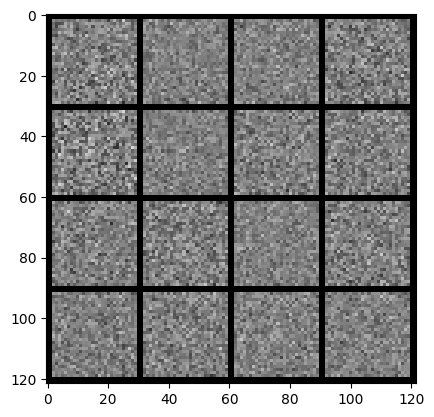

In [48]:
x,y=next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])
noise=gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)